In [1]:
import pandas as pd
import numpy as np

# This function creates 50 "fake" charging sessions
def make_my_data(num_sessions=50):
    all_rows = []
    for session in range(num_sessions):
        time = 0
        pressure = 10.0 # Starts at 10 bar
        temp = 30.0     # Starts at 30 degrees

        while temp < 50: # Stop when it gets too hot
            # PT3402 is the pressure pushing gas into the bottle
            pt3402 = 130.0 + np.random.normal(0, 1)

            # Physics: Pressure goes up, so Temperature goes up
            pressure += (pt3402 - pressure) * 0.05
            temp += (pt3402 - pressure) * 0.02 + np.random.normal(0, 0.1)

            all_rows.append([session, time, pt3402, pressure, temp])
            time += 1

    df = pd.DataFrame(all_rows, columns=['Session', 'Seconds', 'PT3402', 'RCTPI', 'RCGTI'])
    return df

# Create it and save it
my_data = make_my_data()
my_data.to_csv('isro_data.csv', index=False)
print("SUCCESS: Your dataset 'isro_data.csv' is ready!")

SUCCESS: Your dataset 'isro_data.csv' is ready!


In [2]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 1. Prepare the data for the AI
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(my_data[['PT3402', 'RCTPI', 'RCGTI']])

# 2. Tell the AI to look at 10 seconds of history
X, y = [], []
for i in range(len(scaled_values) - 15):
    X.append(scaled_values[i:i+10]) # Past 10 seconds
    y.append(scaled_values[i+15, 2]) # Predict Temp 5 seconds in future
X, y = np.array(X), np.array(y)

# 3. Build the Brain (The Model)
model = Sequential([
    LSTM(50, input_shape=(10, 3)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# 4. Start Training
print("AI is now learning the patterns...")
model.fit(X, y, epochs=5, verbose=1)
print("TRAINING FINISHED!")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


AI is now learning the patterns...
Epoch 1/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2972
Epoch 2/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0911
Epoch 3/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0794
Epoch 4/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0673
Epoch 5/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0593
TRAINING FINISHED!


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


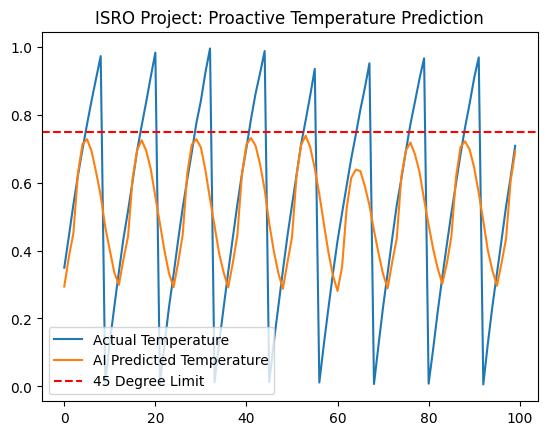

In [3]:
import matplotlib.pyplot as plt

# Let's predict the temperature for the first session
predictions = model.predict(X[:100])

plt.plot(y[:100], label='Actual Temperature')
plt.plot(predictions, label='AI Predicted Temperature')
plt.axhline(y=0.75, color='r', linestyle='--', label='45 Degree Limit') # 0.75 is roughly 45C scaled
plt.legend()
plt.title("ISRO Project: Proactive Temperature Prediction")
plt.show()

In [4]:
# This code converts the AI's "0 to 1" numbers back into real Temperature
predicted_scaled = model.predict(X[-1:]) # Look at the very last second of data
actual_temp_celsius = scaler.inverse_transform([[0, 0, predicted_scaled[0][0]]])[0][2]

print(f"The AI predicts the temperature will be {actual_temp_celsius:.2f}°C in 1 minute.")

if actual_temp_celsius > 44.5:
    print("ACTION: AI suggests cutting down charging NOW to prevent overheating.")
else:
    print("ACTION: Safe to continue charging.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
The AI predicts the temperature will be 42.60°C in 1 minute.
ACTION: Safe to continue charging.
